## 1. Introduction

This notebook presents a more in-depth analysis of the training dataset structure.

The naive approaches we have considered treat the dataset at a sentence level and we have seen that their performance on the testing dataset is not very good. What we observed (and hope to exploit) is that the training dataset is structure into paragraphs!

Funnily enough, the testing dataset may also have such a structure, which we can exploit in the post-processing.

It makes sense to understand the dataset more in depth in order to build better models, but we are also justified by the following meta-observation: our naive models with the right post-processing were able to reach the same performance as fine-tuned transformers trained naively. So it is not enough to have a powerful architecture to obtain good results.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [12]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else:
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [13]:
fname = "./drive/MyDrive/Colab_Projects/RITAL/datasets/AFDpresidentutf8/corpus.tache1.learn.utf8.txt"
pres_alltxts, pres_alllabs = load_pres(fname)

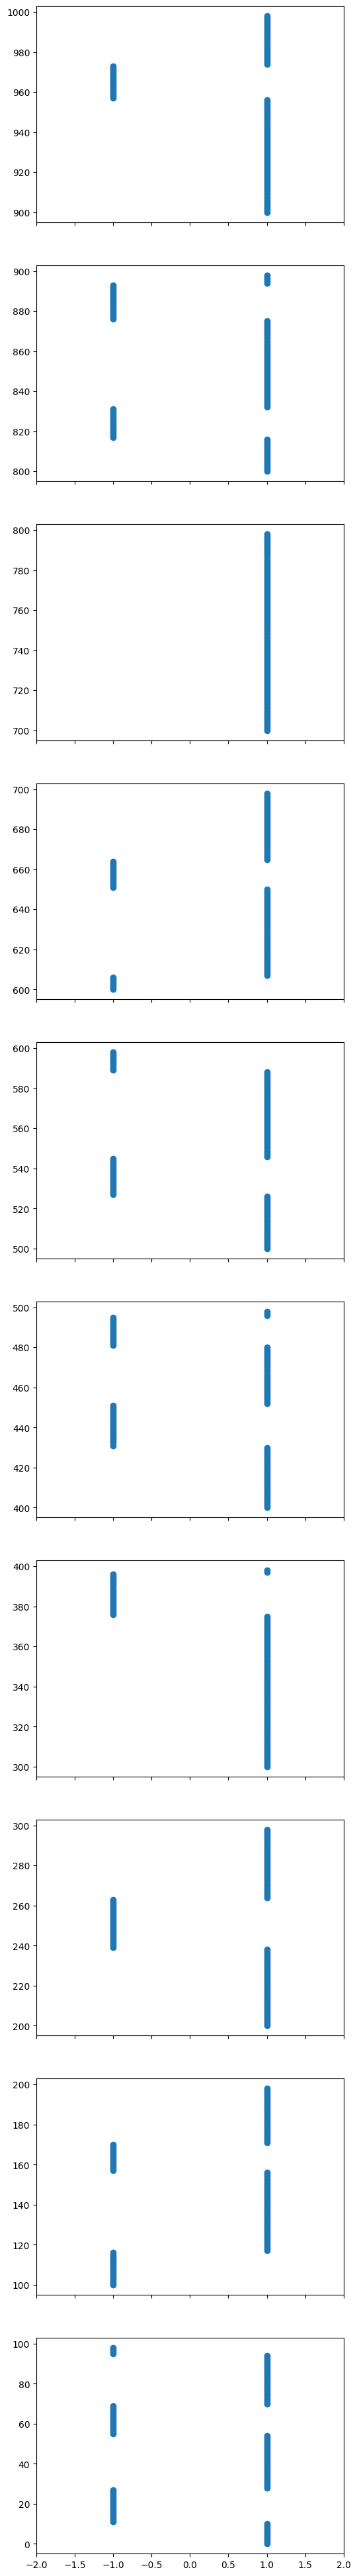

In [14]:
# let's first visualize the organization of the dataset
# (found a rather hacky way to visualize how the intervals cover the label set)
label_range = range(len(pres_alllabs))

fig, axs = plt.subplots(10, 1, figsize=(6, 50), sharex=True)

for i in range(10):
  axs[i].set_xlim(-2, 2)
  axs[i].scatter(pres_alllabs[(9 - i) * 100:(10 - i) * 100 - 1], label_range[(9 - i) * 100:(10 - i) * 100 - 1])
plt.savefig("drive/MyDrive/Colab_Projects/RITAL/plots/intervals.png")
plt.show()

Range of speech length for M:  3 39
Range of speech length for C:  3 952


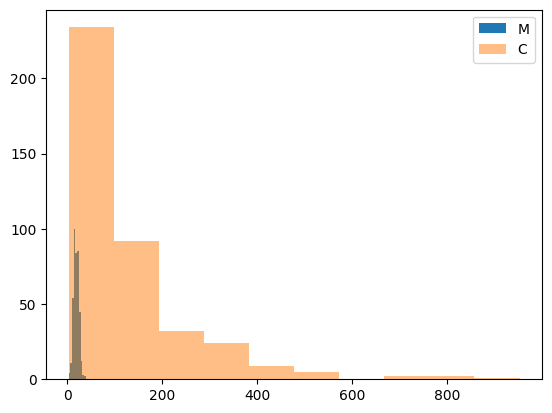

In [15]:
# let's also analyse this numerically in order to find:
# 1. the minimum and the maximum chunk length (for each speaker)
# 2. the distributions of chunk lengths per speaker
# NOTE: these shouldn't necessarily be considered features of the speakers since they can be tricked by how the dataset is presented to us

chunks_M = dict()
chunks_C = dict()
start = 1

for i in range(1, len(pres_alllabs)):
  if pres_alllabs[i] != pres_alllabs[i-1]:
    if pres_alllabs[i-1] == -1:
      chunks_M[start] = i - start
    else:
      chunks_C[start] = i - start
    start = i

if pres_alllabs[-1] == -1:
  chunks_M[start] = len(pres_alllabs) - start
else:
  chunks_C[start] = len(pres_alllabs) - start

# find min and max for each speaker
min_M = min(chunks_M.values())
max_M = max(chunks_M.values())
min_C = min(chunks_C.values())
max_C = max(chunks_C.values())

print("Range of speech length for M: ", min_M, max_M)
print("Range of speech length for C: ", min_C, max_C)

# we see an incredibly long speech from C; is this a single topic?
# inspecting the dataset manually, thank to the numerical tags we see that this chunk is actually formed from a few different discussion

# plot the chunk length distributions
M_lengths = list(chunks_M.values())
C_lengths = list(chunks_C.values())

plt.hist(M_lengths, alpha=1, label="M")
plt.hist(C_lengths, alpha=0.5, label="C")
plt.legend(loc='upper right')
plt.savefig("drive/MyDrive/Colab_Projects/RITAL/plots/chunk_lengths_no_split.png")
plt.show()

In [16]:
# ok, what if we load the dataset ourselves and keep track of the speech index when chunking
def load_with_index(fname):
  alltxts = []
  alllabs = []
  allidxs = []
  s=codecs.open(fname, 'r','utf-8') # pour régler le codage
  while True:
      txt = s.readline()
      if(len(txt))<5:
          break

      idx = re.sub(r"<([0-9]*):[0-9]*:.>.*","\\1",txt)
      lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
      txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)

      if lab.count('M') >0:
          alllabs.append(-1)
      else:
          alllabs.append(1)
      alltxts.append(txt)
      allidxs.append(int(idx[:-1]))
  return alltxts,alllabs,allidxs

fname = "./drive/MyDrive/Colab_Projects/RITAL/datasets/AFDpresidentutf8/corpus.tache1.learn.utf8.txt"
pres_alltxts, pres_alllabs, pres_allidxs = load_with_index(fname)

print(pres_alltxts[:10])
print(pres_alllabs[:10])
print(pres_allidxs[:10])

[" Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", " D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.\n", " C'est toujours très émouvant de venir en Afrique car c'est probablement l'une des rares terres du monde où l'on ait conservé cette convivialité, cette amitié, ce respect de l'autre qui s'expriment avec chaleur, avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent.\n", ' Aucun citoyen français ne peut être indifférent à un séjour à Brazzaville.\n', ' Le Congo, que naguère le <nom> qualifia de "refuge pour la liberté", de "base de départ pour la libération", de "môle pour la Résistance", comment ne pas être heureux de s\'y retrouver ?\n', ' Comment ne pas y voir un signe ?\n', " Brazzaville n'est pas une capitale ordinaire.\n", ' Les voies de la libre disposition des peuples et de leur coopération furent exploré

Range of speech length for M:  3 39
Range of speech length for C:  1 368


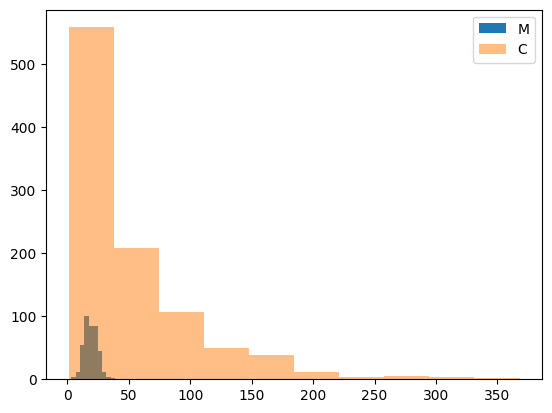

In [17]:
chunks_M = dict()
chunks_C = dict()
start = 0

for i in range(1, len(pres_alllabs)):
  if pres_alllabs[i] != pres_alllabs[i-1] or pres_allidxs[i] != pres_allidxs[i - 1]:
    if pres_alllabs[i-1] == -1:
      chunks_M[start] = i - start
    else:
      chunks_C[start] = i - start
    start = i

if pres_alllabs[-1] == -1:
  chunks_M[start] = len(pres_alllabs) - start
else:
  chunks_C[start] = len(pres_alllabs) - start

# find min and max for each speaker
min_M = min(chunks_M.values())
max_M = max(chunks_M.values())
min_C = min(chunks_C.values())
max_C = max(chunks_C.values())

print("Range of speech length for M: ", min_M, max_M)
print("Range of speech length for C: ", min_C, max_C)

# we see an incredibly long speech from C; is this a single topic?
# inspecting the dataset manually, thank to the numerical tags we see that this chunk is actually formed from a few different discussion

# plot the chunk length distributions
M_lengths = list(chunks_M.values())
C_lengths = list(chunks_C.values())

plt.hist(M_lengths, alpha=1, label="M")
plt.hist(C_lengths, alpha=0.5, label="C")
plt.legend(loc='upper right')
plt.savefig("drive/MyDrive/Colab_Projects/RITAL/plots/chunk_lengths_with_split.png")
plt.show()

In [18]:
# save chunks to drive (just to not repeat code between notebooks)
import json

with open("./drive/MyDrive/Colab_Projects/RITAL/chunks/presidents_M.json", "w") as f:
  json.dump(chunks_M, f)

with open("./drive/MyDrive/Colab_Projects/RITAL/chunks/presidents_C.json", "w") as f:
  json.dump(chunks_C, f)

In [19]:
for key, value in chunks_C.items():
  if value == 368 or value == 1:
    print(key)

print(chunks_M)
print(chunks_C)
print("Number of chunks: ", len(chunks_M) + len(chunks_C))

15319
31525
34920
40343
52770
53668
{11: 17, 55: 15, 95: 22, 157: 14, 239: 25, 376: 21, 431: 21, 481: 15, 527: 19, 589: 18, 651: 14, 817: 15, 876: 18, 957: 17, 1005: 21, 1064: 22, 1157: 20, 1321: 24, 1417: 13, 1471: 22, 1636: 24, 1747: 26, 1833: 30, 1915: 20, 1982: 17, 2117: 20, 2175: 22, 2294: 24, 2367: 15, 2420: 23, 2550: 18, 2604: 17, 2674: 19, 2790: 14, 2891: 27, 2995: 28, 3046: 15, 3087: 23, 3164: 23, 3379: 22, 3478: 21, 3662: 25, 3741: 32, 3853: 20, 3972: 26, 4011: 15, 4143: 26, 4324: 25, 4390: 21, 4461: 19, 4511: 26, 4573: 8, 4625: 18, 4723: 21, 4780: 14, 4884: 35, 4976: 26, 5183: 21, 5596: 23, 5708: 21, 5758: 18, 5825: 19, 6014: 27, 6232: 16, 6292: 13, 6434: 22, 6492: 20, 6882: 24, 6997: 25, 7085: 25, 7196: 12, 7311: 16, 7381: 21, 7468: 19, 7682: 19, 7806: 5, 7888: 20, 8015: 30, 8120: 10, 8228: 19, 8279: 18, 8356: 18, 8424: 12, 8510: 12, 8600: 21, 8754: 22, 8807: 22, 8910: 18, 8948: 26, 9088: 23, 9235: 19, 9371: 22, 9452: 15, 9515: 12, 9585: 26, 9672: 19, 9796: 23, 10003: 18, 1

Can have some short chunks, should we exclude them?

How are changes between paragraphs detected? To humans we would think that changes in paragraphs correspond to changes in topic. This would mean detecting the speaker would be a combination of detecting topic changes + detecting speaker style. We think it is reasonable to thus try to detect the topics present in our dataset.

Of course, this a difficult task. The naive approach we take is applying a clustering algorithm and manually inspecting some of the clusters.

## 2. Understanding topics

In [20]:
# load encodings we computed in a previous notebook
embeddings = np.load("./drive/MyDrive/Colab_Projects/RITAL/embeddings/presidents_camembert_base.npy")

# use average pooling to construct a chunk embedding
chunk_embeddings = []
for key, value in chunks_M.items():
  chunk_embeddings.append(np.mean(embeddings[key:key+value], axis=0))
for key, value in chunks_C.items():
  chunk_embeddings.append(np.mean(embeddings[key:key+value], axis=0))

chunk_embeddings = np.array(chunk_embeddings)
print(chunk_embeddings.shape)

(1387, 768)


In [21]:
# cluster the chunks and try to manually identify topics
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(chunk_embeddings)
clusters = dict()
print(type(kmeans.labels_))
print(len(kmeans.labels_))
print(len(chunk_embeddings))

for chunk, cluster in zip(range(len(chunk_embeddings)), list(kmeans.labels_)):
  if cluster not in clusters:
    clusters[cluster] = []
  clusters[cluster].append(chunk)

for key, value in clusters.items():
  print(key, len(value))

# for one of the clusters with less points, try to manually verify the topic similarity
print(clusters[16])

chunk_order = []
for key, value in chunks_M.items():
  chunk_order.append((key, value))
for key, value in chunks_C.items():
  chunk_order.append((key, value))

chunk_order = np.array(chunk_order)
print(chunk_order[clusters[16]])

<class 'numpy.ndarray'>
1387
1387
4 104
1 56
18 166
7 49
2 58
14 74
11 110
17 86
10 36
0 76
9 95
8 46
3 106
12 97
15 71
5 45
6 36
13 21
19 44
16 11
[503, 562, 787, 935, 944, 994, 1072, 1149, 1255, 1289, 1306]
[[ 4581     4]
 [ 8276     3]
 [21208    12]
 [30320     3]
 [30826    12]
 [33480    13]
 [39029     3]
 [43374     4]
 [49266     8]
 [51545     5]
 [52770     1]]


We have manually inspected the texts identified as belonging to cluster 16. While most share some similarities (class C, lots of titles used, thank expressed), at least two are outliers (longer, main topic not shared with most texts) making this clustering method not robust or predictable.

What would change if we instead computed a paragraph-level embedding? The following challenges would remain:
1. lot of manual effort to identify topics and clusters
2. no immediate way to relate this to the testing dataset